In [1]:
# Control variable: Set to True to skip training and only load/visualize existing results
# Useful for viewing history, plotting curves, or running inference without training
SKIP_TRAINING = False  # Set to True to skip the training loop

# Telegram notifications configuration
telegram_config = {
    "notify_every": 1,  # Send notification every N epochs (0 to disable)
    "model_name": "UNet",
    "degradation_info": {
        "type": "Quantization with Dithering",
        "description": "2-bit quantization with random dithering",
        "settings": {
            "Bits per channel": 2,
            "Dithering type": "Random",
            "Color levels": "4 (2-bit)",
        },
    },
}

## 1. Setup & Imports

In [ ]:
import warnings

from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import cv2

from src.degradations import generate_degraded_dataset_auto
from src.losses import CombinedLoss
from src.models import UNet
from src.training import get_dataloaders, run_training
from src.utils import (
    load_checkpoint,
    plot_image_comparison,
    plot_inference_results,
    plot_training_curves,
    print_training_summary,
    setup_or_resume_experiment,
    resume_training,
    download_div2k_dataset,
)
from src.evaluation import ImageRestorationEvaluator

warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER
CUDA memory: 12.88 GB


## 2. Configuration

In [ ]:
config = {
    # Resume Training
    "resume_from_checkpoint": False,
    "resume_experiment": "latest",
    # Training
    "batch_size": 8,
    "num_epochs": 100,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    # Data
    "patch_size": 128,
    "patches_per_image": 20,
    "num_workers": 4,
    # Model
    "model_features": 64,
    "model_bilinear": False,
    # Loss
    "loss_alpha": 0.84,
    "loss_beta": 0.16,
    # Degradation
    "degradation_type": "quantization",
    "bits_per_channel": 2,
    "dithering_type": "random",
    # Optimization
    "scheduler": "cosine",
    "warmup_epochs": 5,
    "min_lr": 1e-6,
    # Early stopping
    "patience": 5,
    # Checkpoints
    "save_every": 5,
    "val_every": 2,
    # Mixed Precision
    "use_amp": True,
    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}

# Set seed for reproducibility
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

print("\n📋 Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


📋 Configuration:
   resume_from_checkpoint: True
   resume_experiment: latest
   train_degraded_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_train_HR
   train_clean_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\raw\DIV2K_train_HR
   val_degraded_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_valid_HR
   val_clean_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\raw\DIV2K_valid_HR
   batch_size: 16
   num_epochs: 35
   learning_rate: 0.0001
   weight_decay: 1e-05
   patch_size: 128
   patches_per_image: 20
   num_workers: 4
   model_features: 64
   model_bilinear: False
   loss_alpha: 0.84
   loss_beta: 0.16
   bits_per_channel: 2
   dithering_type: random
   scheduler: cosine
   warmup_epochs: 5
   min_lr: 1e-06
   patience: 5
   save_every: 5
   val_every: 2
   use_amp: True
   device: cuda
   seed: 42


## 3. Create Output Directories

In [ ]:
# Setup experiment directories (new or resume existing)
exp_dir, checkpoints_dir, samples_dir, logs_dir = setup_or_resume_experiment(
    model_name="unet",
    degradation="dithering/random",
    config=config,
    resume_from_checkpoint=config["resume_from_checkpoint"],
    resume_experiment=config["resume_experiment"],
    custom_name="upsample",
)


🔄 RESUME MODE: Loading existing experiment

📁 Experiment: 20260102_235821_v2



## 4. Setup TensorBoard

In [5]:
# TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

print(f"\n📊 TensorBoard logs: {logs_dir}")
print(f"   Run: tensorboard --logdir {logs_dir.absolute()}")


📊 TensorBoard logs: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\logs
   Run: tensorboard --logdir c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\logs


## 5. Generate Degraded Datasets

Generate corrupted versions of DIV2K images using 2-bit random dithering

In [ ]:
# Download and prepare the DIV2K dataset
download_div2k_dataset()

# Generate degraded datasets (auto-generates paths and checks for existence)
train_degraded_dir, train_clean_dir = generate_degraded_dataset_auto(
    dataset_split="DIV2K_train_HR",
    degradation_type="quantization",
    bits_per_channel=config["bits_per_channel"],
    dithering_type=config["dithering_type"],
    seed=config["seed"],
)

val_degraded_dir, val_clean_dir = generate_degraded_dataset_auto(
    dataset_split="DIV2K_valid_HR",
    degradation_type="quantization",
    bits_per_channel=config["bits_per_channel"],
    dithering_type=config["dithering_type"],
    seed=config["seed"],
)

# Update config with dataset paths
config["train_degraded_dir"] = str(train_degraded_dir)
config["train_clean_dir"] = str(train_clean_dir)
config["val_degraded_dir"] = str(val_degraded_dir)
config["val_clean_dir"] = str(val_clean_dir)

print("\nDataset paths:")
print(f"Training degraded: {train_degraded_dir}")
print(f"Training clean: {train_clean_dir}")
print(f"Validation degraded: {val_degraded_dir}")
print(f"Validation clean: {val_clean_dir}")

✅ DIV2K raw dataset already exists
✅ Degraded datasets already exist:
   Train: 800 images in c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_train_HR
   Val: 100 images in c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_valid_HR

⏭️  Skipping generation (delete folders to regenerate)


## 6. Create Dataloaders

In [7]:
# Create dataloaders
train_loader, val_loader = get_dataloaders(
    train_degraded_dir=config["train_degraded_dir"],
    train_clean_dir=config["train_clean_dir"],
    val_degraded_dir=config["val_degraded_dir"],
    val_clean_dir=config["val_clean_dir"],
    batch_size=config["batch_size"],
    patch_size=config["patch_size"],
    patches_per_image=config["patches_per_image"],
    num_workers=config["num_workers"],
)

print(f"\n   Batches per epoch: {len(train_loader)} train, {len(val_loader)} val")

Loaded 800 valid images for train set
Loaded 100 valid images for val set
📊 Dataset Summary:
   Train: 16000 patches from 800 images
   Val:   2000 patches from 100 images
   Batch size: 16
   Patch size: 128x128

   Batches per epoch: 1000 train, 125 val


## 7. Visualize Sample Batch

Batch shapes:
   Degraded: torch.Size([16, 3, 128, 128])
   Clean: torch.Size([16, 3, 128, 128])
   Range: [-1.000, 1.000]


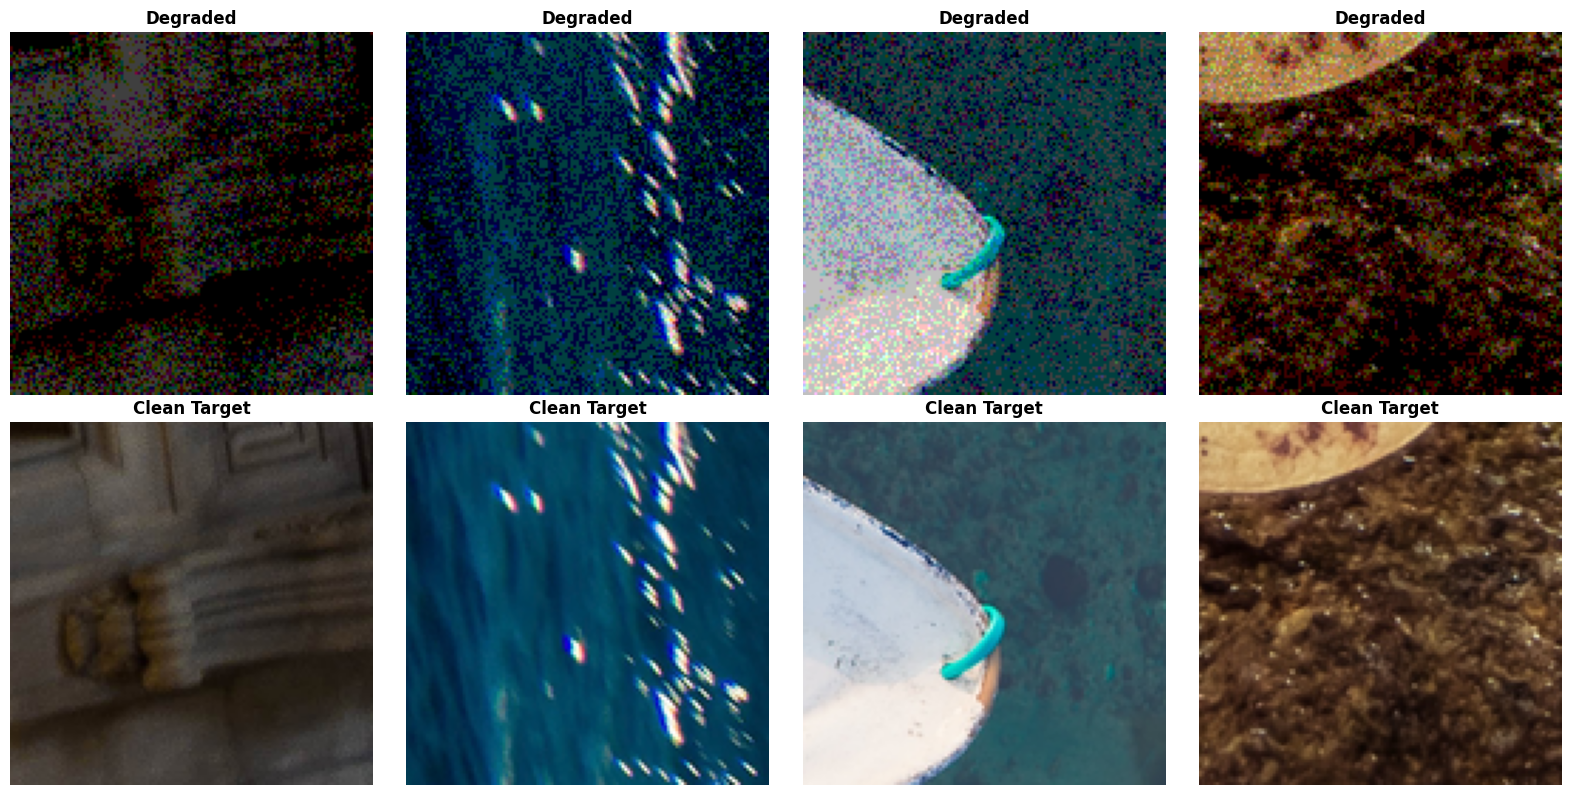


✅ Sample batch saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\samples\training_samples.png


In [8]:
# Visualize a batch
degraded_batch, clean_batch = next(iter(train_loader))

print("Batch shapes:")
print(f"   Degraded: {degraded_batch.shape}")
print(f"   Clean: {clean_batch.shape}")
print(f"   Range: [{degraded_batch.min():.3f}, {degraded_batch.max():.3f}]")

# Show sample using utility function
plot_image_comparison(
    degraded_batch=degraded_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "training_samples.png",
)

print(f"\n✅ Sample batch saved to {samples_dir / 'training_samples.png'}")

## 8. Initialize Model, Loss, Optimizer

In [9]:
# Create model
model = UNet(
    in_channels=3,
    out_channels=3,
    features=config["model_features"],
    bilinear=config["model_bilinear"],
).to(config["device"])

print("\n🤖 Model: UNet")
print(f"   Parameters: {model.get_num_params():,}")
print(f"   Device: {config['device']}")

# Loss function
criterion = CombinedLoss(alpha=config["loss_alpha"], beta=config["loss_beta"]).to(
    config["device"]
)

print(f"\n📉 Loss: L1 + SSIM (α={config['loss_alpha']}, β={config['loss_beta']})")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

print("\n⚙️  Optimizer: AdamW")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config['weight_decay']}")

# Learning rate scheduler
scheduler = None
if config["scheduler"] == "cosine":
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config["num_epochs"] - config["warmup_epochs"],
        eta_min=config["min_lr"],
    )
    print("\n📅 Scheduler: CosineAnnealingLR")
    print(f"   Warmup epochs: {config['warmup_epochs']}")
    print(f"   Min LR: {config['min_lr']}")
else:
    print("\n📅 No scheduler configured")

# Resume from checkpoint if enabled
start_epoch = 0
initial_best_loss = float("inf")
initial_best_epoch = 0
initial_history = None

if config["resume_from_checkpoint"]:
    (
        checkpoint_info,
        start_epoch,
        initial_history,
        resume_exp_dir,
        initial_best_epoch,
    ) = resume_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        experiment_path=config["resume_experiment"],
        model_name="unet",
        degradation="dithering/random",
        device=config["device"],
    )
    initial_best_loss = (
        checkpoint_info["metrics"].get("val", {}).get("loss", float("inf"))
    )

    # Verify that resume_exp_dir matches our exp_dir
    if resume_exp_dir != exp_dir:
        print("⚠️  Warning: Resume experiment mismatch!")
        print(f"   Expected: {exp_dir}")
        print(f"   Got: {resume_exp_dir}")
        print(f"   Using: {exp_dir}")
else:
    print("\n🆕 Starting fresh training (resume_from_checkpoint=False)")


🤖 Model: UNet
   Parameters: 31,037,763
   Device: cuda

📉 Loss: L1 + SSIM (α=0.84, β=0.16)

⚙️  Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 1e-05

📅 Scheduler: CosineAnnealingLR
   Warmup epochs: 5
   Min LR: 1e-06

🔄 Resuming Training from Checkpoint

📂 Loading most recent experiment: 20260102_235821_v2
📥 Loading checkpoint from: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\checkpoints\best_model.pth
✅ Loaded model from epoch 18 (loss: 0.09495401191711426)
📊 Loaded history (18 validation points)
📦 Resuming from epoch 19 (checkpoint at epoch 18)
   Best model val_loss: 0.0950



## 9. Training Loop

In [10]:
if not SKIP_TRAINING:
    # Run training
    history, best_info = run_training(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=config["device"],
        num_epochs=config["num_epochs"],
        checkpoints_dir=checkpoints_dir,
        writer=writer,
        warmup_epochs=config["warmup_epochs"],
        learning_rate=config["learning_rate"],
        patience=config["patience"],
        save_every=config["save_every"],
        val_every=config["val_every"],
        start_epoch=start_epoch,
        initial_best_loss=initial_best_loss,
        initial_best_epoch=initial_best_epoch,  # Pass best epoch from checkpoint
        initial_history=initial_history,  # Continue from previous history
        use_amp=config["use_amp"],  # Enable/disable mixed precision training
        config=config,  # Training configuration
        telegram_config=telegram_config,  # Telegram notifications config
    )

    # Extract best model info
    best_epoch = best_info["best_epoch"]
    best_val_loss = best_info["best_val_loss"]

    print(f"✅ Training history saved to {exp_dir / 'history.json'}")
else:
    # Skip training: Load existing history and best model info
    print("\n" + "=" * 80)
    print("⏭️  SKIP_TRAINING = True: Loading existing results")
    print("=" * 80 + "\n")

    from src.utils.experiment import load_training_history

    try:
        history = load_training_history(exp_dir)
        print(f"✅ Loaded history from {exp_dir / 'history.json'}")
        print(f"   Total epochs: {len(history['train_loss'])}")

        # Find best epoch from history
        if history.get("val_loss"):
            best_val_loss = min(history["val_loss"])
            best_epoch = history["val_loss"].index(best_val_loss) + 1
            print(f"   Best epoch: {best_epoch} (val_loss: {best_val_loss:.4f})")
        else:
            best_val_loss = float("inf")
            best_epoch = 0
            print("   No validation history found")

        # Create best_info dict for consistency
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    except FileNotFoundError:
        print(f"⚠️  No history found in {exp_dir}")
        print("   Creating empty history (train first to generate data)")
        history = {
            "train_loss": [],
            "train_l1": [],
            "train_ssim": [],
            "val_loss": [],
            "val_l1": [],
            "val_ssim": [],
            "lr": [],
        }
        best_epoch = 0
        best_val_loss = float("inf")
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    print("=" * 80 + "\n")

📊 Continuing from previous history (18 epochs recorded)
⚡ Mixed Precision Training: ENABLED (fp16)
📱 Telegram notifications: ENABLED (every 1 epochs)

🔄 Resuming Training from Epoch 19
   Will train epochs 19 to 35
   Previous best loss: 0.0950

📱 Training start notification sent to Telegram



📊 Overall Progress:  51%|#####1    | 18/35 epochs [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 19/35
  Train - Loss: 0.1017 | L1: 0.0659 | SSIM: 0.710
  LR: 0.000056 | Time: 271.6s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 20 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 20 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 20/35
  Train - Loss: 0.1018 | L1: 0.0660 | SSIM: 0.710
  Val   - Loss: 0.0966 | L1: 0.0609 | SSIM: 0.716
  LR: 0.000051 | Time: 303.2s (inference: 41.4s) | VRAM: 1398MB
  💾 Checkpoint saved (epoch 20)
  📱 Telegram notification sent (validation #1)
--------------------------------------------------------------------------------


Epoch 21 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 21/35
  Train - Loss: 0.1011 | L1: 0.0653 | SSIM: 0.711
  LR: 0.000045 | Time: 262.9s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 22 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 22 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 22/35
  Train - Loss: 0.1002 | L1: 0.0644 | SSIM: 0.712
  Val   - Loss: 0.0939 | L1: 0.0586 | SSIM: 0.721
  LR: 0.000040 | Time: 298.4s (inference: 35.5s) | VRAM: 1398MB
  ✅ Best model saved! (val_loss: 0.0939)
  📱 Telegram notification sent (validation #2)
--------------------------------------------------------------------------------


Epoch 23 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 23/35
  Train - Loss: 0.0991 | L1: 0.0634 | SSIM: 0.713
  LR: 0.000035 | Time: 260.7s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 24 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 24 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 24/35
  Train - Loss: 0.0985 | L1: 0.0632 | SSIM: 0.716
  Val   - Loss: 0.0919 | L1: 0.0575 | SSIM: 0.728
  LR: 0.000030 | Time: 297.3s (inference: 35.5s) | VRAM: 1398MB
  ✅ Best model saved! (val_loss: 0.0919)
  📱 Telegram notification sent (validation #3)
--------------------------------------------------------------------------------


Epoch 25 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 25/35
  Train - Loss: 0.0982 | L1: 0.0627 | SSIM: 0.715
  LR: 0.000026 | Time: 261.1s | VRAM: 1398MB
  💾 Checkpoint saved (epoch 25)
--------------------------------------------------------------------------------


Epoch 26 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 26 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 26/35
  Train - Loss: 0.0973 | L1: 0.0621 | SSIM: 0.718
  Val   - Loss: 0.0916 | L1: 0.0565 | SSIM: 0.725
  LR: 0.000021 | Time: 298.5s (inference: 35.6s) | VRAM: 1398MB
  ✅ Best model saved! (val_loss: 0.0916)
  📱 Telegram notification sent (validation #4)
--------------------------------------------------------------------------------


Epoch 27 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 27/35
  Train - Loss: 0.0969 | L1: 0.0614 | SSIM: 0.717
  LR: 0.000017 | Time: 316.3s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 28 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 28 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 28/35
  Train - Loss: 0.0962 | L1: 0.0608 | SSIM: 0.718
  Val   - Loss: 0.0910 | L1: 0.0565 | SSIM: 0.728
  LR: 0.000014 | Time: 297.5s (inference: 35.4s) | VRAM: 1398MB
  ✅ Best model saved! (val_loss: 0.0910)
  📱 Telegram notification sent (validation #5)
--------------------------------------------------------------------------------


Epoch 29 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 29/35
  Train - Loss: 0.0961 | L1: 0.0607 | SSIM: 0.718
  LR: 0.000010 | Time: 260.4s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 30 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 30 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 30/35
  Train - Loss: 0.0954 | L1: 0.0603 | SSIM: 0.720
  Val   - Loss: 0.0904 | L1: 0.0560 | SSIM: 0.729
  LR: 0.000008 | Time: 296.6s (inference: 35.4s) | VRAM: 1398MB
  ✅ Best model saved! (val_loss: 0.0904)
  💾 Checkpoint saved (epoch 30)
  📱 Telegram notification sent (validation #6)
--------------------------------------------------------------------------------


Epoch 31 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 31/35
  Train - Loss: 0.0955 | L1: 0.0600 | SSIM: 0.718
  LR: 0.000005 | Time: 260.0s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 32 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 32 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 32/35
  Train - Loss: 0.0946 | L1: 0.0598 | SSIM: 0.723
  Val   - Loss: 0.0896 | L1: 0.0554 | SSIM: 0.731
  LR: 0.000003 | Time: 295.5s (inference: 35.2s) | VRAM: 1398MB
  ✅ Best model saved! (val_loss: 0.0896)
  📱 Telegram notification sent (validation #7)
--------------------------------------------------------------------------------


Epoch 33 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 33/35
  Train - Loss: 0.0947 | L1: 0.0598 | SSIM: 0.722
  LR: 0.000002 | Time: 260.8s | VRAM: 1398MB
--------------------------------------------------------------------------------


Epoch 34 [Train]:   0%|          | 0/1000 [00:00<?] 

Epoch 34 [Val]:   0%|          | 0/125 [00:00<?] 


Epoch 34/35
  Train - Loss: 0.0943 | L1: 0.0595 | SSIM: 0.723
  Val   - Loss: 0.0903 | L1: 0.0555 | SSIM: 0.727
  LR: 0.000001 | Time: 295.2s (inference: 35.2s) | VRAM: 1398MB
  📱 Telegram notification sent (validation #8)
--------------------------------------------------------------------------------


Epoch 35 [Train]:   0%|          | 0/1000 [00:00<?] 


Epoch 35/35
  Train - Loss: 0.0943 | L1: 0.0596 | SSIM: 0.723
  LR: 0.000001 | Time: 262.1s | VRAM: 1398MB
  💾 Checkpoint saved (epoch 35)
--------------------------------------------------------------------------------

✅ Training Completed!
   Best model: epoch 32 with val_loss 0.0896
   Validation points saved: 35

✅ Training history saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\history.json


## 10. Plot Training Curves

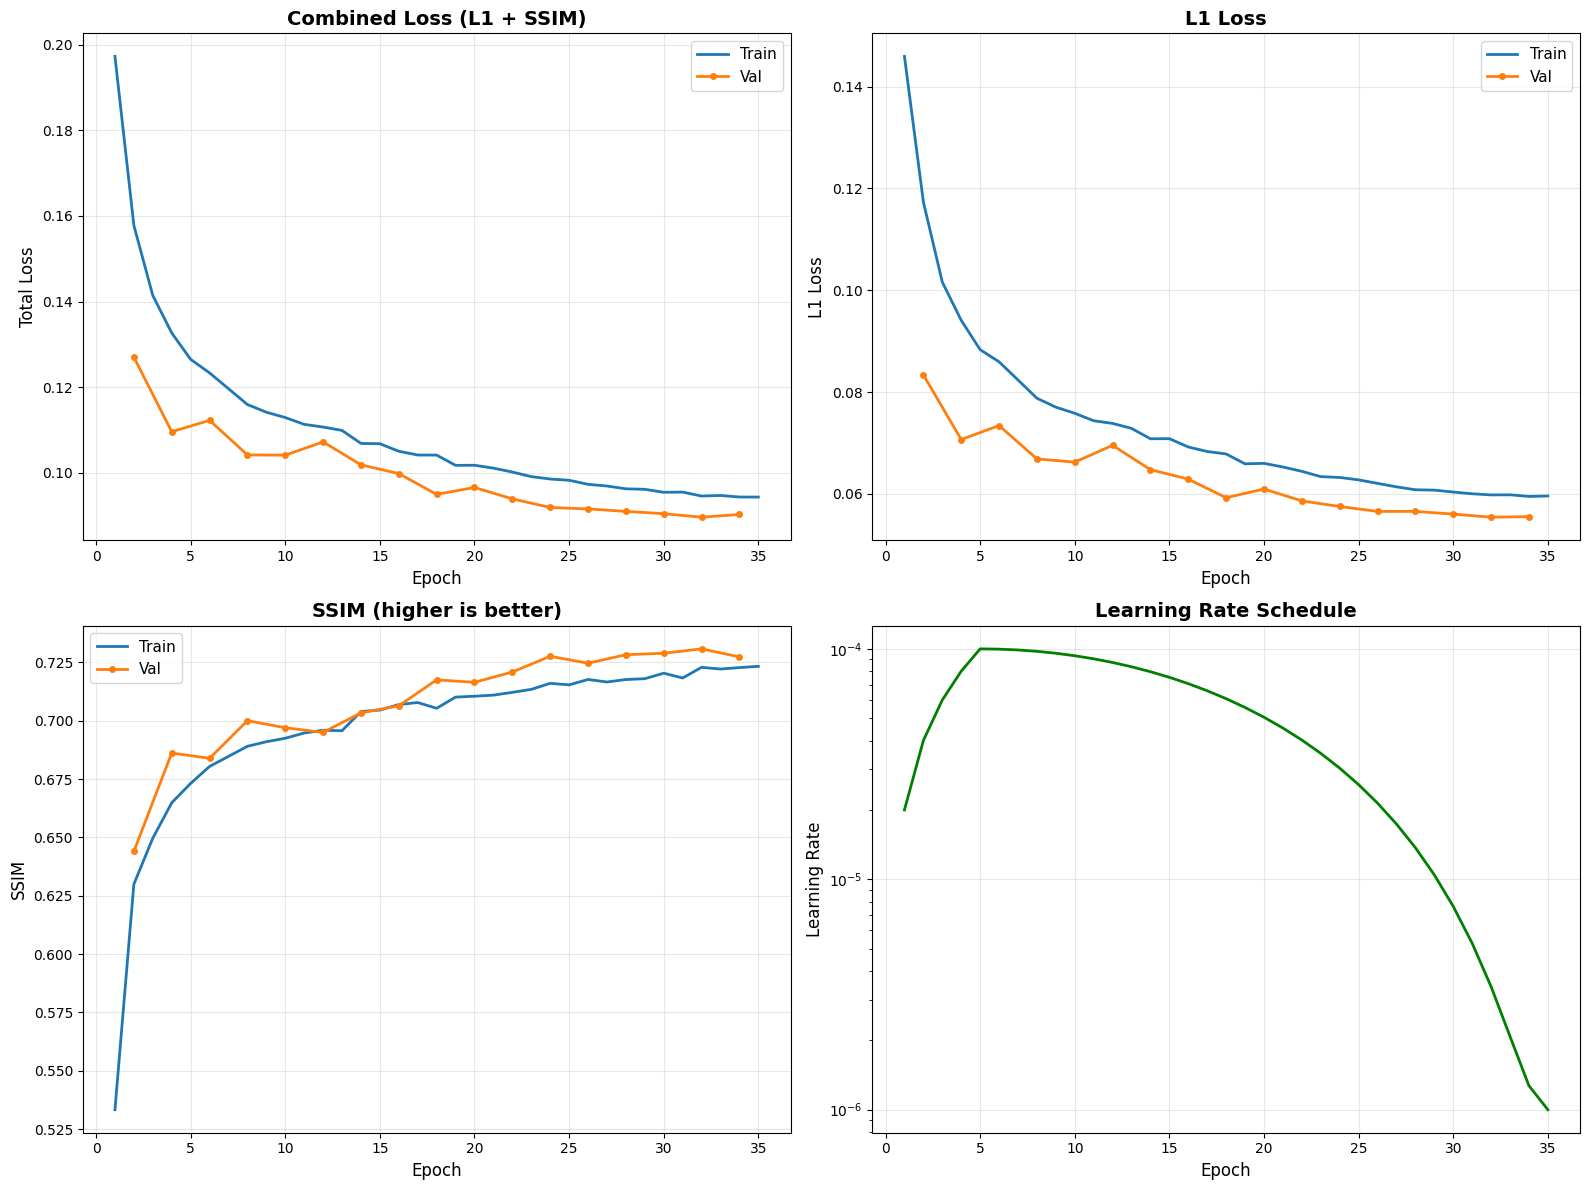


✅ Training curves saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\training_curves.png


In [11]:
# Plot training curves using utility function
plot_training_curves(history=history, save_path=exp_dir / "training_curves.png")

print(f"\n✅ Training curves saved to {exp_dir / 'training_curves.png'}")

## 11. Test Inference on Validation Samples

✅ Loaded best model from epoch 32


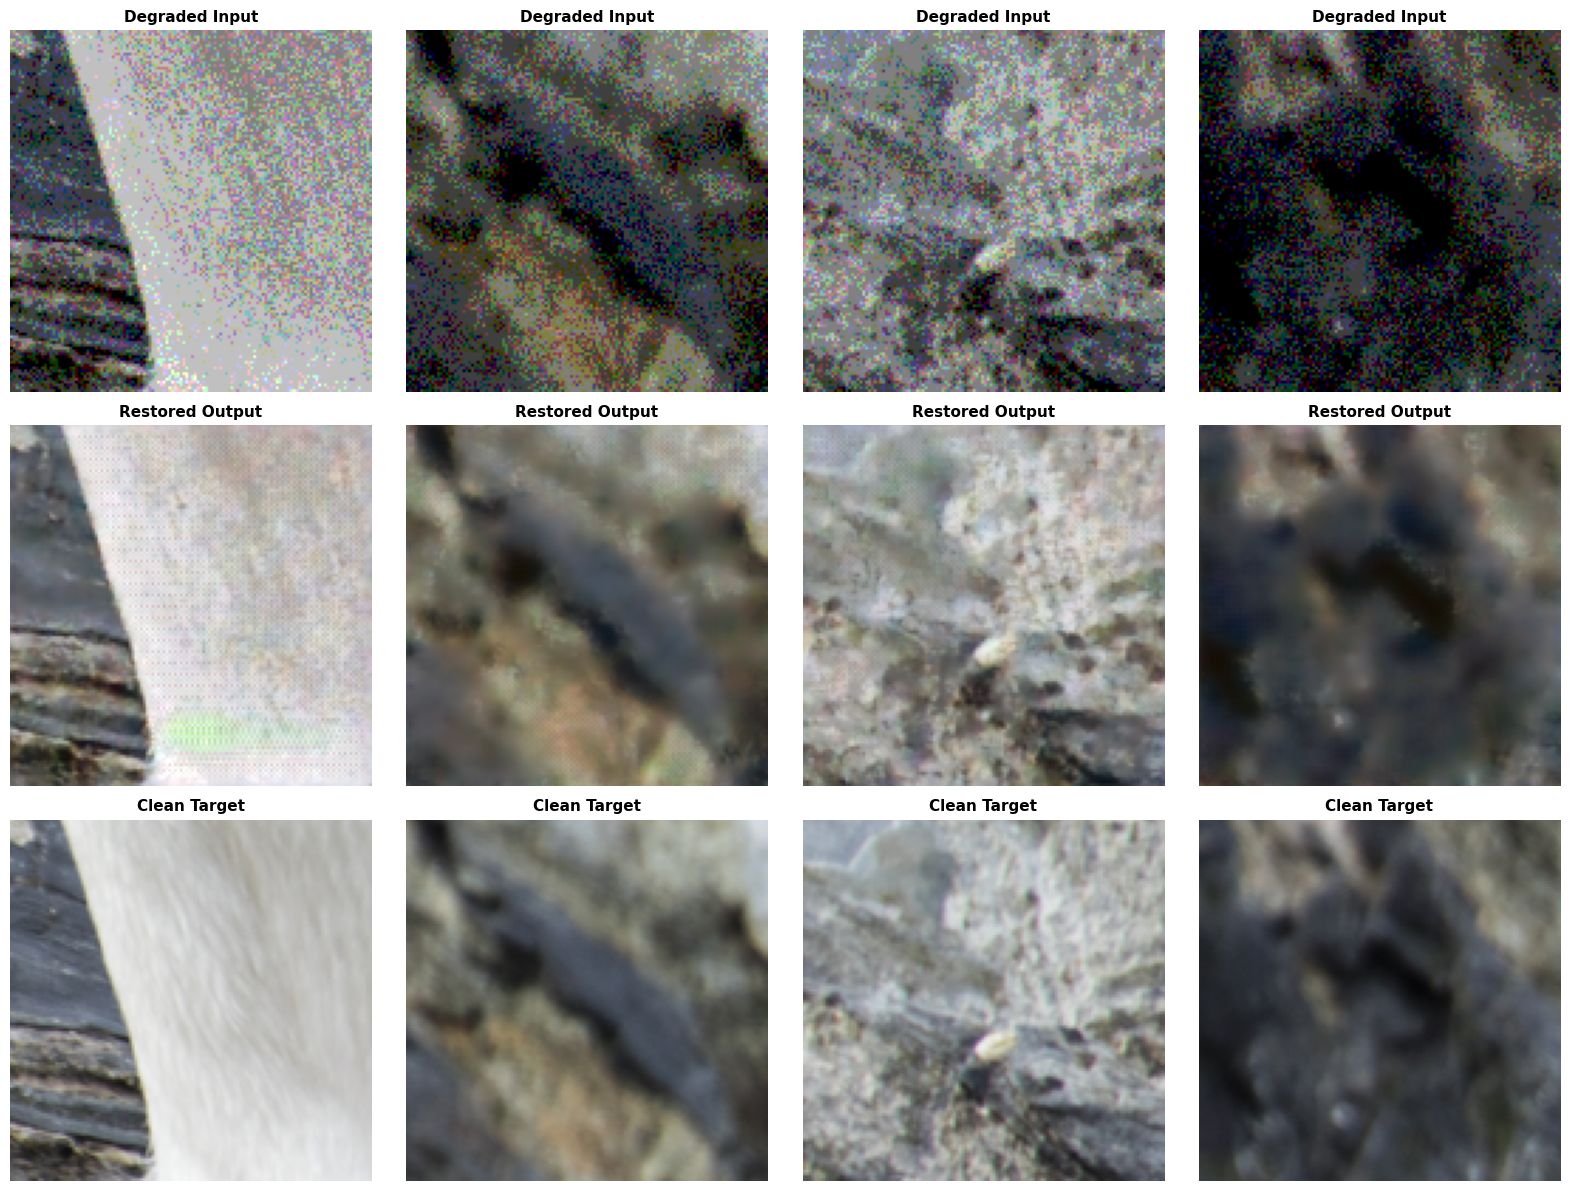


✅ Inference results saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\samples\inference_results.png


In [12]:
# Load best model
checkpoint_info = load_checkpoint(
    checkpoints_dir / "best_model.pth", model=model, device=config["device"]
)

print(f"✅ Loaded best model from epoch {checkpoint_info['epoch']}")

# Get validation batch
degraded_batch, clean_batch = next(iter(val_loader))
degraded_batch = degraded_batch.to(config["device"])
clean_batch = clean_batch.to(config["device"])

# Inference
with torch.no_grad():
    restored_batch = model(degraded_batch)

# Visualize results using utility function
plot_inference_results(
    degraded_batch=degraded_batch,
    restored_batch=restored_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "inference_results.png",
)

print(f"\n✅ Inference results saved to {samples_dir / 'inference_results.png'}")

## 12. Summary

In [13]:
# Print training summary
print_training_summary(
    history=history,
    best_epoch=best_epoch,
    best_val_loss=best_val_loss,
    exp_dir=exp_dir,
    checkpoints_dir=checkpoints_dir,
    samples_dir=samples_dir,
    logs_dir=logs_dir,
)


📊 TRAINING SUMMARY

Experiment directory: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2

Validation points saved: 35
Best epoch: 32

Best Validation Metrics:
  Loss: 0.0896
  L1: 0.0554
  SSIM: 0.7308

Final Training Metrics:
  Loss: 0.0943
  L1: 0.0596
  SSIM: 0.7233

Performance Statistics:
  Total training time: 2.18h (7832s)
  Total epochs trained: 35
  Avg epoch time: 300.4s
  Avg inference time: 35.9s
  Peak memory: 483MB

Saved files:
  Best model: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\checkpoints\best_model.pth
  Training history: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\history.json
  Training curves: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\training_curves.png
  Inference samples: c:\Users\giuse\Codici\Workspace\Image-Enhancement\exp

## 13. Quantitative Evaluation on Full-Resolution Images

Evaluate the model on entire validation images using sliding window inference.

In [14]:
# Create evaluator
evaluator = ImageRestorationEvaluator(
    model=model,
    device=config["device"],
    patch_size=config["patch_size"],
    overlap=32,  # Overlap for smooth blending
)

print("\n🔍 Evaluator configured:")
print(f"   Patch size: {config['patch_size']}")
print("   Overlap: 32 pixels")
print(f"   Device: {config['device']}")


🔍 Evaluator configured:
   Patch size: 128
   Overlap: 32 pixels
   Device: cuda


In [15]:
# Evaluate on validation set (limit to 10 images for speed)
eval_results = evaluator.evaluate_dataset(
    degraded_dir=config["val_degraded_dir"],
    clean_dir=config["val_clean_dir"],
    output_dir=exp_dir / "restored_images",
    save_outputs=True,  # Save restored images
    max_images=10,  # Change to None to evaluate all images
)

# Print summary
evaluator.print_summary(eval_results)

# Save results
evaluator.save_results(eval_results, exp_dir / "evaluation_metrics.json")


📊 Evaluating 10 images...


Processing images:   0%|          | 0/10 [00:00<?, ?it/s]


EVALUATION SUMMARY

📊 Evaluated 10 images

📈 Mean Metrics:
   PSNR: 28.64 ± 1.80 dB
   SSIM: 0.7923 ± 0.0473
   MAE: 0.028073 ± 0.006653
   MSE: 0.001513 ± 0.000824

🏆 Best Image (highest PSNR):
   0809.png
   PSNR: 30.61 dB, SSIM: 0.8627

⚠️  Worst Image (lowest PSNR):
   0807.png
   PSNR: 24.17 dB, SSIM: 0.7724


✅ Results saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_235821_v2\evaluation_metrics.json


## 14. Visualize Full-Resolution Restoration

Show best and worst restoration results on full images.


🏆 Best result: 0801.png
   PSNR: 29.86 dB, SSIM: 0.8712


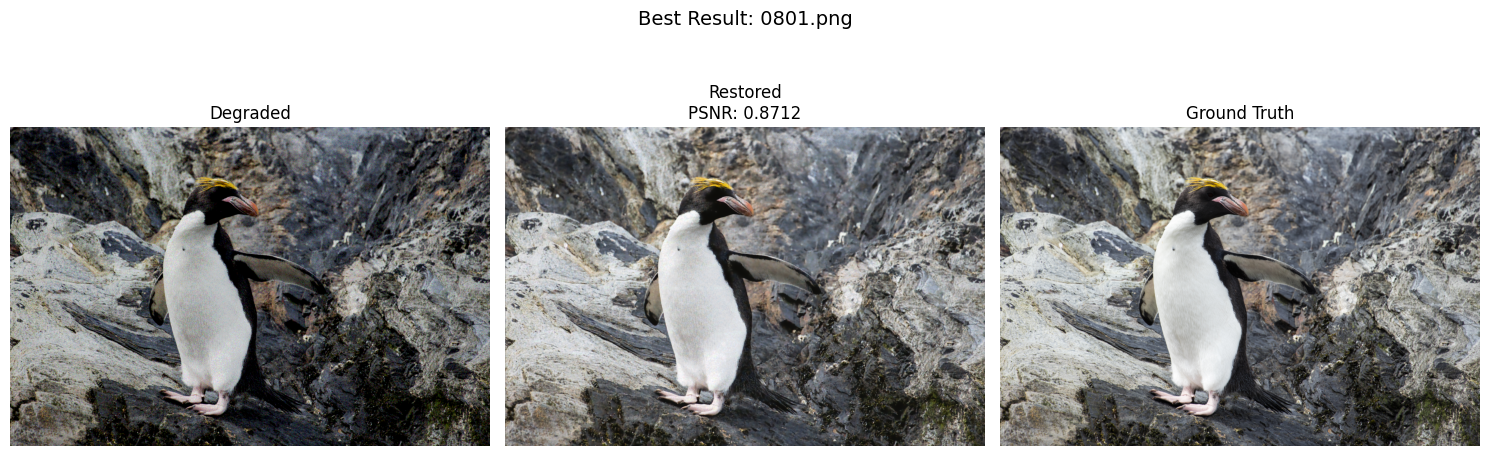


⚠️ Worst result: 0808.png
   PSNR: 27.45 dB, SSIM: 0.7399


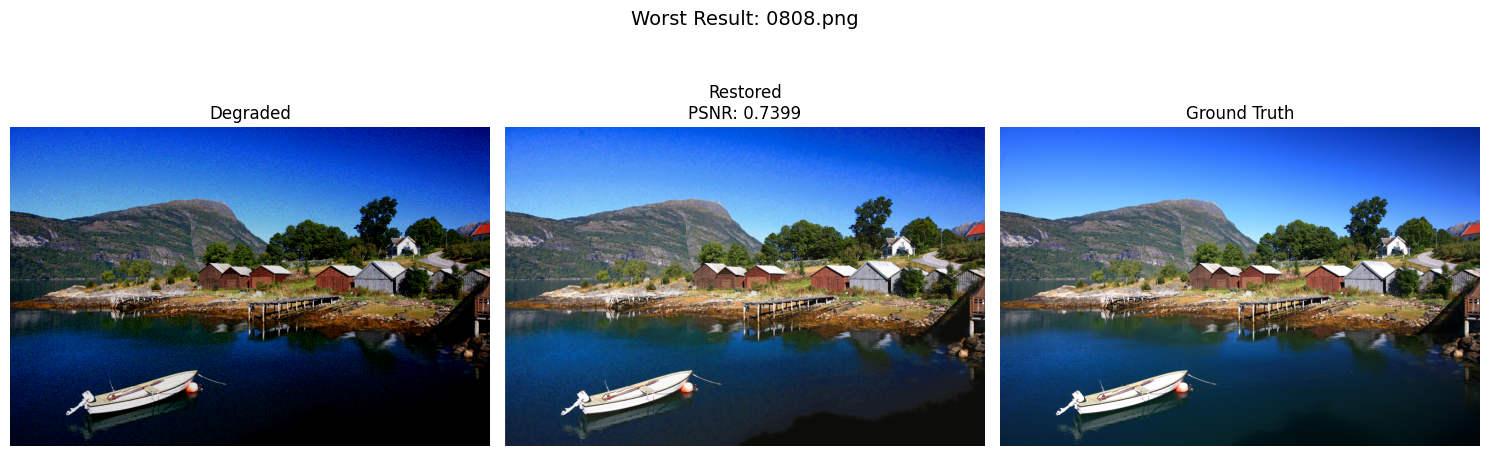

In [ ]:
# Get best and worst images
best_img = max(eval_results["per_image"], key=lambda x: x["psnr"])
worst_img = min(eval_results["per_image"], key=lambda x: x["psnr"])


# Load images for visualization
def load_image_trio(filename):
    degraded_path = Path(config["val_degraded_dir"]) / filename
    clean_path = Path(config["val_clean_dir"]) / filename
    restored_path = exp_dir / "restored_images" / filename

    degraded = cv2.cvtColor(cv2.imread(str(degraded_path)), cv2.COLOR_BGR2RGB)
    clean = cv2.cvtColor(cv2.imread(str(clean_path)), cv2.COLOR_BGR2RGB)
    restored = cv2.cvtColor(cv2.imread(str(restored_path)), cv2.COLOR_BGR2RGB)

    return degraded, restored, clean


# Visualize best result
print(f"\n🏆 Best result: {best_img['filename']}")
print(f"   PSNR: {best_img['psnr']:.2f} dB, SSIM: {best_img['ssim']:.4f}")

deg, res, cln = load_image_trio(best_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(
    f"Restored\nPSNR: {best_img['psnr']:.2f} dB    SSIM: {best_img['ssim']:.4f}"
)
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Best Result: {best_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "best_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()

# Visualize worst result
print(f"\n⚠️ Worst result: {worst_img['filename']}")
print(f"   PSNR: {worst_img['psnr']:.2f} dB, SSIM: {worst_img['ssim']:.4f}")

deg, res, cln = load_image_trio(worst_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(
    f"Restored\nPSNR: {worst_img['psnr']:.2f} dB    SSIM: {worst_img['ssim']:.4f}"
)
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Worst Result: {worst_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "worst_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()